In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
from time import time

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy
from sklearn import svm
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool

import random

In [2]:
# Here we are testing if svm can really tell the difference between two classes,
# which are 7n and 7N
hisDir = '/oasis/projects/nsf/csd395/ruogu/svm3/histogram/';
labels = ['7n', '7N'];

In [8]:
# Prepare training data
fileNames = os.listdir(hisDir);
NonBg = [(np.load(hisDir + f), labels.index(f[:-4])) for f in fileNames if f[:-4] in labels];

In [9]:
print len(NonBg);

2


In [12]:
X = [];
y = [];
for data in NonBg:
    label = data[1];
    for i in range(0, data[0].shape[0]):
        X.append(data[0][i]);
        y.append(label);

print len(X);
print len(y);

2000
2000


In [13]:
X = np.asarray(X);
y = np.asarray(y);
raw_data = zip(X, y);
random.shuffle(raw_data);

In [14]:
n_training = len(raw_data);
training_X = np.asarray([x[0] for x in raw_data]);
training_y = np.asarray([x[1] for x in raw_data]);

In [15]:
# Train in parallel.
def train_job(i):
    xi = training_X[i];
    his = 0.5 * np.sum(training_X + xi - np.abs(training_X - xi), axis=1); # Equals to min(xi, xj)
    return (i, his);

start = time();
pool = Pool(processes=16); # This is a compution-heavy work, so we can have more process, like 15.
result = pool.map(train_job, range(0, n_training));
end = time();
print "Kernel calculation takes {} sec.".format(end - start);

Kernel calculation takes 34.1696078777 sec.


In [16]:
sorted(result, key=lambda x: x[0]);
myKernel = np.asarray([v[1] for v in result]);
myKernel = myKernel.reshape(n_training, n_training);

In [17]:
# Train SVM
clf = svm.SVC(kernel="precomputed", decision_function_shape='ovr');
clf.fit(myKernel, training_y);

In [18]:
# Training accuracy
predict_labels_train = clf.predict(myKernel);
n_correct_train = 0;
for i in range(n_training):
    if predict_labels_train[i] == training_y[i]:
        n_correct_train += 1;
print "Training accuracy: {}".format(1.0*n_correct_train / n_training);

Training accuracy: 0.985


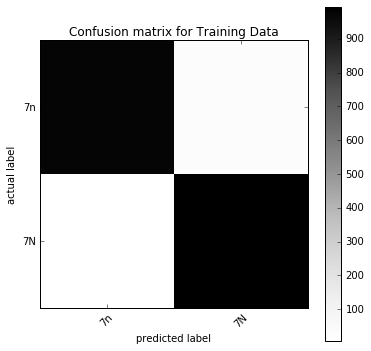

In [19]:
cm_train = confusion_matrix(training_y, predict_labels_train);
plt.figure(figsize=(6, 6));
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Greys);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Confusion matrix for Training Data');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45);
plt.yticks(tick_marks, labels);

In [20]:
np.save('/oasis/projects/nsf/csd395/ruogu/svm3/training_X.npy', training_X);

In [21]:
import pickle
pickle.dump(clf, open('/oasis/projects/nsf/csd395/ruogu/svm3/clf.p', 'wb'));

In [22]:
print len(clf.support_);

469
